In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357299 sha256=03d4f2588fa90770df1824c86e6731f23a4ee330ffeb4d5dd79f618b767b1245
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load the fashion dataset
file_path = 'fashion_dataset.csv'
fashion_data = pd.read_csv(file_path)

In [ ]:
fashion_data.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,...,link,ratings,review,Month,Price (USD),user_id1,user_id2,user_id3,user_id4,user_id5
0,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,...,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46,93810,67912,12506,31747,17972
1,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29,24592,54541,98358,62538,23573
2,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,...,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39,13278,34966,71797,93928,90931
3,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,...,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39,46048,40972,76426,52622,68556
4,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,...,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33,42098,58790,98835,49226,67898


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.accuracy import rmse
from PIL import Image
from IPython.display import display

# Melt and prepare user-item matrix
user_columns = ['user_id1', 'user_id2', 'user_id3', 'user_id4', 'user_id5']
melted_data = fashion_data.melt(
    id_vars=['id', 'ratings', 'filename', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'Price (USD)'],
    value_vars=user_columns, var_name='user_column', value_name='user_id'
).drop(columns=['user_column']).dropna()

# Prepare the data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(melted_data[['user_id', 'id', 'ratings']], reader)


In [ ]:
from surprise.model_selection import RandomizedSearchCV

# Smaller parameter distribution for quicker tuning
param_dist = {'n_factors': [50, 100, 150], 'lr_all': [0.003, 0.005, 0.007], 'reg_all': [0.01, 0.02, 0.03], 'n_epochs': [20, 30]}


# Use RandomizedSearchCV for faster tuning
rs = RandomizedSearchCV(SVD, param_dist, measures=['rmse'], cv=3, n_iter=4)  # n_iter limits the number of samples
rs.fit(data)

# Get the best SVD model and print RMSE
best_svd = rs.best_estimator['rmse']
print("Best RMSE:", rs.best_score['rmse'])
print("Best Params:", rs.best_params['rmse'])

Best RMSE: 0.9320390624383625
Best Params: {'n_factors': 150, 'lr_all': 0.007, 'reg_all': 0.02, 'n_epochs': 30}


In [ ]:
# Get the best SVD model and print RMSE
best_svd = rs.best_estimator['rmse']
print("Best RMSE:", rs.best_score['rmse'])
print("Best Params:", rs.best_params['rmse'])

Best RMSE: 0.9320390624383625
Best Params: {'n_factors': 150, 'lr_all': 0.007, 'reg_all': 0.02, 'n_epochs': 30}


In [ ]:

# Fit the best model on the full training data
best_svd.fit(data.build_full_trainset())

In [ ]:
'''# Function to get top recommendations for a specific user using the best SVD model
def get_svd_recommendations(user_id, svd_model, fashion_data, top_n=5):
    user_id = str(user_id)
    all_items = fashion_data['id'].unique()
    rated_items = melted_data[melted_data['user_id'] == user_id]['id'].tolist()
    unrated_items = [item for item in all_items if item not in rated_items]

    # Predict ratings for unrated items
    predictions = [svd_model.predict(user_id, item) for item in unrated_items]

    # Sort by predicted rating and select top N
    top_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]

    # Get details for the recommended items
    recommended_items = [pred.iid for pred in top_recommendations]
    recommended_details = fashion_data[fashion_data['id'].isin(recommended_items)]

    return recommended_details'''

"# Function to get top recommendations for a specific user using the best SVD model\ndef get_svd_recommendations(user_id, svd_model, fashion_data, top_n=5):\n    user_id = str(user_id)\n    all_items = fashion_data['id'].unique()\n    rated_items = melted_data[melted_data['user_id'] == user_id]['id'].tolist()\n    unrated_items = [item for item in all_items if item not in rated_items]\n\n    # Predict ratings for unrated items\n    predictions = [svd_model.predict(user_id, item) for item in unrated_items]\n\n    # Sort by predicted rating and select top N\n    top_recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)[:top_n]\n\n    # Get details for the recommended items\n    recommended_items = [pred.iid for pred in top_recommendations]\n    recommended_details = fashion_data[fashion_data['id'].isin(recommended_items)]\n\n    return recommended_details"

In [ ]:
'''# Function to display recommendations with images
def display_recommendations_with_images(user_id, svd_model, fashion_data, top_n=5, img_size=(200, 200)):
    recommended_details = get_svd_recommendations(user_id, svd_model, fashion_data, top_n)

    print(f"Recommended items for User ID {user_id}:")

    # Display images and additional information for each recommended item
    for _, item in recommended_details.iterrows():
        filename = item['filename']
        image_path = f"/content/drive/MyDrive/Images/{filename}"  # Adjust the path as necessary

        try:
            # Open, resize, and display the image
            img = Image.open(image_path)
            img = img.resize(img_size)  # Resize to specified dimensions
            print(f"Item ID: {item['id']}, Gender: {item['gender']}, Price: {item['Price (USD)']}, Category: {item['masterCategory']}, Subcategory: {item['subCategory']}")
            display(img)
        except Exception as e:
            print(f"Image for item {item['id']} could not be found at {image_path}. Error: {e}")'''


Recommended items for User ID 93810: (Gender: Women)
Displaying image for Target User ID: 93810


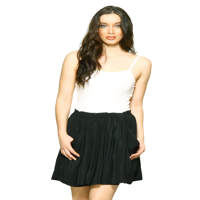

Item ID: 45387, Gender: Women, Price: 49, Category: Footwear, Subcategory: Shoes


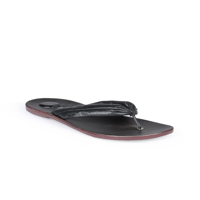

Item ID: 38594, Gender: Women, Price: 40, Category: Apparel, Subcategory: Topwear


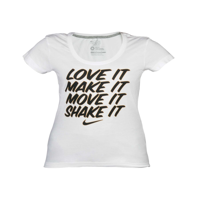

Item ID: 10658, Gender: Women, Price: 22, Category: Apparel, Subcategory: Topwear


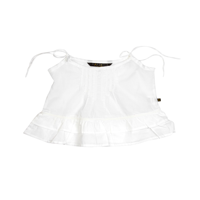

Item ID: 24539, Gender: Women, Price: 38, Category: Apparel, Subcategory: Topwear


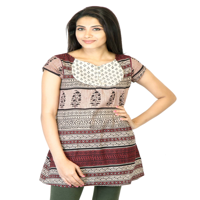

Item ID: 37966, Gender: Women, Price: 13, Category: Footwear, Subcategory: Shoes


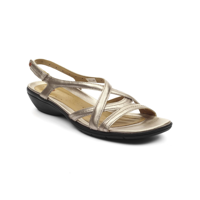

In [ ]:
import pandas as pd
from PIL import Image
from IPython.display import display
from surprise import SVD
# Function to display recommendations with images for the specific gender
def display_recommendations_with_images(user_id, svd_model, fashion_data, top_n=5, img_size=(200, 200)):
    # Get the gender of the target user from the fashion_data DataFrame
    user_gender_row = fashion_data[fashion_data['user_id1'] == user_id]  # Assuming the target user id is in 'user_id1'
    if user_gender_row.empty:
        print(f"No data found for user ID: {user_id}")
        return

    target_user_gender = user_gender_row['gender'].values[0]

    # Filter the fashion items based on gender
    gender_filtered_fashion_data = fashion_data[fashion_data['gender'] == target_user_gender]

    # Get top N recommendations for the target user
    recommended_details = get_svd_recommendations(user_id, svd_model, gender_filtered_fashion_data, top_n)

    print(f"Recommended items for User ID {user_id}: (Gender: {target_user_gender})")

    # Display image of the target user
    target_user_image_path = fashion_data[fashion_data['user_id1'] == user_id]['filename'].values[0]
    target_user_image = Image.open(f"/content/drive/MyDrive/Images/{target_user_image_path}")
    target_user_image = target_user_image.resize(img_size)
    print(f"Displaying image for Target User ID: {user_id}")
    display(target_user_image)

    # Display images and additional information for each recommended item
    for _, item in recommended_details.iterrows():
        filename = item['filename']
        image_path = f"/content/drive/MyDrive/Images/{filename}"  # Adjust the path as necessary

        try:
            # Open, resize, and display the image
            img = Image.open(image_path)
            img = img.resize(img_size)  # Resize to specified dimensions
            print(f"Item ID: {item['id']}, Gender: {item['gender']}, Price: {item['Price (USD)']}, Category: {item['masterCategory']}, Subcategory: {item['subCategory']}")
            display(img)
        except Exception as e:
            print(f"Image for item {item['id']} could not be found at {image_path}. Error: {e}")

# Example function to get top N recommendations (Assuming it's implemented)
def get_svd_recommendations(user_id, svd_model, fashion_data, top_n=5):
    # This function would generate recommendations based on the trained SVD model
    # Placeholder for SVD recommendation code
    # This function should return a DataFrame of recommended items for the user

    # Example: Simulate recommendations
    recommendations = fashion_data.sample(n=top_n)  # Replace this with actual recommendations logic
    return recommendations

# Example usage:
user_id = 93810  # Example user_id to test the recommendation and image display
display_recommendations_with_images(user_id, best_svd, fashion_data, top_n=5, img_size=(200, 200))


Recommended items for User ID 24592: (Gender: Men)
Displaying image for Target User ID: 24592


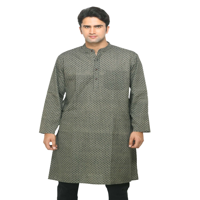

Item ID: 15749, Gender: Men, Price: 25, Category: Apparel, Subcategory: Bottomwear


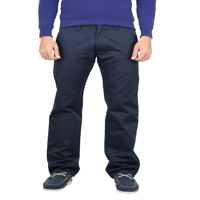

Item ID: 34641, Gender: Men, Price: 53, Category: Footwear, Subcategory: Shoes


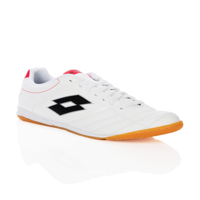

Item ID: 16199, Gender: Men, Price: 43, Category: Apparel, Subcategory: Topwear


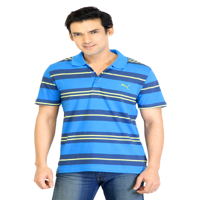

Item ID: 7004, Gender: Men, Price: 32, Category: Apparel, Subcategory: Topwear


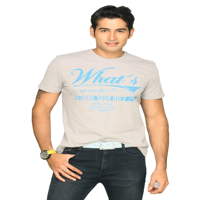

In [ ]:
# Example usage:
user_id = 24592  # Example user_id to test the recommendation and image display
display_recommendations_with_images(user_id, best_svd, fashion_data, top_n=4, img_size=(200, 200))

Recommended items for User ID 95181: (Gender: Men)
Displaying image for Target User ID: 95181


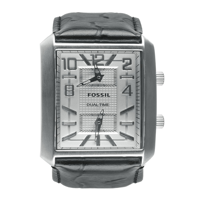

Item ID: 16165, Gender: Men, Price: 48, Category: Footwear, Subcategory: Shoes


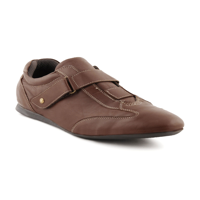

Item ID: 17264, Gender: Men, Price: 35, Category: Apparel, Subcategory: Topwear


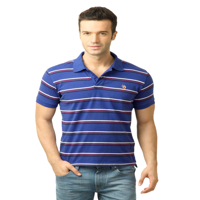

Item ID: 27787, Gender: Men, Price: 28, Category: Accessories, Subcategory: Wallets


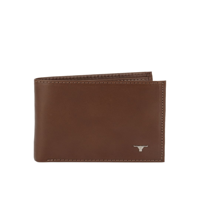

In [ ]:
# Example usage:
user_id = 95181  # Example user_id to test the recommendation and image display
display_recommendations_with_images(user_id, best_svd, fashion_data, top_n=3, img_size=(200, 200))

Recommended items for User ID 51347: (Gender: Men)
Displaying image for Target User ID: 51347


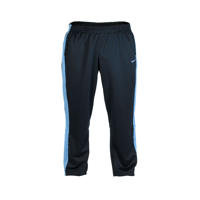

Item ID: 26379, Gender: Men, Price: 16, Category: Apparel, Subcategory: Bottomwear


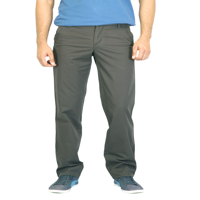

Item ID: 12843, Gender: Men, Price: 36, Category: Apparel, Subcategory: Topwear


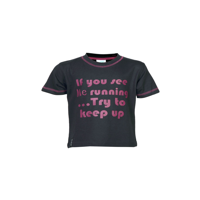

Item ID: 2495, Gender: Men, Price: 44, Category: Footwear, Subcategory: Shoes


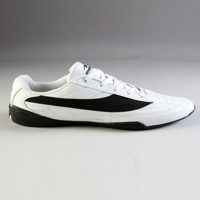

Item ID: 19895, Gender: Men, Price: 36, Category: Accessories, Subcategory: Belts


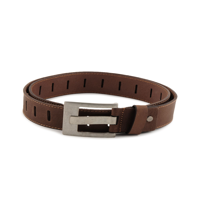

Item ID: 7069, Gender: Men, Price: 25, Category: Apparel, Subcategory: Topwear


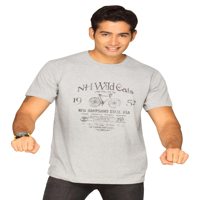

In [ ]:
# Example usage:
user_id = 51347  # Example user_id to test the recommendation and image display
display_recommendations_with_images(user_id, best_svd, fashion_data, top_n=5, img_size=(200, 200))

Recommended items for User ID 28301: (Gender: Women)
Displaying image for Target User ID: 28301


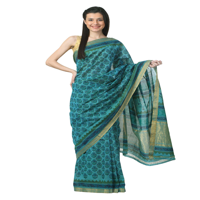

Item ID: 54564, Gender: Women, Price: 17, Category: Apparel, Subcategory: Topwear


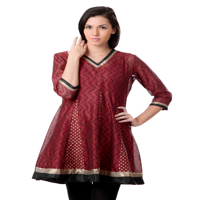

Item ID: 15623, Gender: Women, Price: 41, Category: Apparel, Subcategory: Topwear


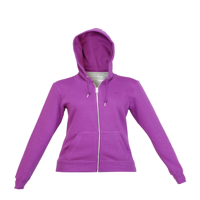

Item ID: 11362, Gender: Women, Price: 42, Category: Apparel, Subcategory: Topwear


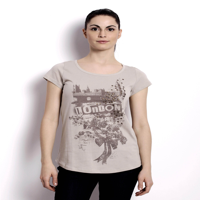

Item ID: 47618, Gender: Women, Price: 14, Category: Footwear, Subcategory: Shoes


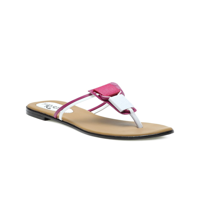

Item ID: 57001, Gender: Women, Price: 34, Category: Footwear, Subcategory: Shoes


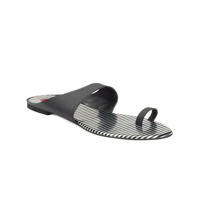

In [ ]:
# Example usage:
user_id = 28301  # Example user_id to test the recommendation and image display
display_recommendations_with_images(user_id, best_svd, fashion_data, top_n=5, img_size=(200, 200))

In [ ]:
# Calculate Precision@K and Recall@K
from collections import defaultdict

def precision_recall_at_k(predictions, k=5, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''
    # Map predictions to each user
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Count relevant and recommended items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K and Recall@K
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    # Average precision and recall across all users
    precision_avg = sum(precisions.values()) / len(precisions)
    recall_avg = sum(recalls.values()) / len(recalls)

    return precision_avg, recall_avg

# Calculate Precision and Recall at K
precision, recall = precision_recall_at_k(predictions, k=5, threshold=3.5)
print(f"Precision@K: {precision}")
print(f"Recall@K: {recall}")

Precision@K: 0.7134249830278344
Recall@K: 0.7826502036659878


Recommendations for User ID 93810 based on input articleType: Skirts (Gender: Women)
Input Item:


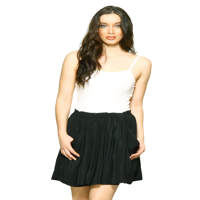

Item ID: 3613, Gender: Women, Price: 41, Category: Apparel, Subcategory: Topwear


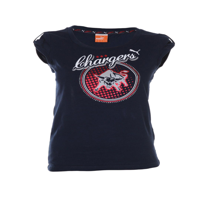

Item ID: 45218, Gender: Women, Price: 50, Category: Accessories, Subcategory: Watches


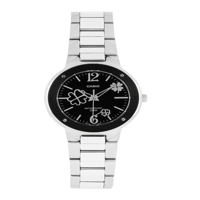

Item ID: 54831, Gender: Women, Price: 49, Category: Accessories, Subcategory: Bags


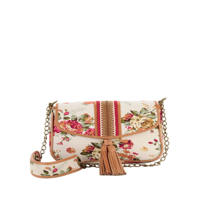

Item ID: 49615, Gender: Women, Price: 49, Category: Footwear, Subcategory: Shoes


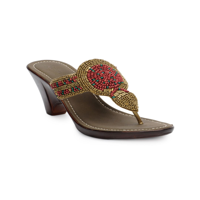

In [ ]:
#19-11-24
import pandas as pd
from PIL import Image
from IPython.display import display
from surprise import SVD

# Function to display complete wear recommendations with unique article types
def display_complete_wear_recommendations(user_id, svd_model, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200)):
    # Get the gender of the target user
    user_data = fashion_data[fashion_data['user_id1'] == user_id]
    if user_data.empty:
        print(f"No data found for user ID: {user_id}")
        return

    target_user_gender = user_data['gender'].iloc[0]

    # Filter the dataset by gender
    gender_filtered_data = fashion_data[fashion_data['gender'] == target_user_gender]

    # Get the input item associated with the user
    input_item = user_data.iloc[0]
    input_article_type = input_item['articleType']

    # Get complementary categories for the input articleType
    complementary_categories = complementary_mapping.get(input_article_type, [])

    if not complementary_categories:
        print(f"No complementary items defined for {input_article_type}.")
        return

    print(f"Recommendations for User ID {user_id} based on input articleType: {input_article_type} (Gender: {target_user_gender})")

    # Display input item image
    try:
        input_image_path = f"/content/drive/MyDrive/Images/{input_item['filename']}"
        input_image = Image.open(input_image_path).resize(img_size)
        print("Input Item:")
        display(input_image)
    except Exception as e:
        print(f"Could not display input item image. Error: {e}")

    # Initialize a list to store recommendations
    recommendations = []

    for category in complementary_categories:
        # Filter the dataset for items matching the current complementary category
        category_items = gender_filtered_data[gender_filtered_data['articleType'] == category]

        if not category_items.empty:
            # Use SVD model to predict ratings for items in this category
            category_recommendations = [
                (item, svd_model.predict(user_id, item['id']).est)
                for _, item in category_items.iterrows()
            ]

            # Select the top-rated item in the category
            if category_recommendations:
                best_item = max(category_recommendations, key=lambda x: x[1])[0]
                recommendations.append(best_item)

    # Display the recommended items
    for item in recommendations:
        try:
            image_path = f"/content/drive/MyDrive/Images/{item['filename']}"
            img = Image.open(image_path).resize(img_size)
            print(
                f"Item ID: {item['id']}, Gender: {item['gender']}, Price: {item['Price (USD)']}, "
                f"Category: {item['masterCategory']}, Subcategory: {item['subCategory']}"
            )
            display(img)
        except Exception as e:
            print(f"Could not display image for Item ID {item['id']}. Error: {e}")
'''
# Example function to simulate SVD-based recommendations
def get_svd_recommendations(user_id, svd_model, valid_items, top_n=5):
    recommendations = []
    for _, item in valid_items.iterrows():
        item_id = item['id']
        est_rating = svd_model.predict(user_id, item_id).est
        recommendations.append((item, est_rating))

    # Sort by predicted rating and return the top N
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    return pd.DataFrame([rec[0] for rec in recommendations[:top_n]])
'''
# Example usage
user_id = 93810  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))


Recommendations for User ID 28301 based on input articleType: Sarees (Gender: Women)
Input Item:


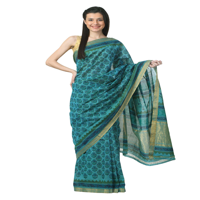

Item ID: 58156, Gender: Women, Price: 53, Category: Accessories, Subcategory: Bags


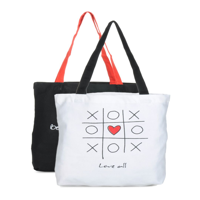

Item ID: 42626, Gender: Women, Price: 44, Category: Accessories, Subcategory: Jewellery


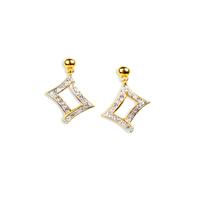

Item ID: 54167, Gender: Women, Price: 40, Category: Accessories, Subcategory: Jewellery


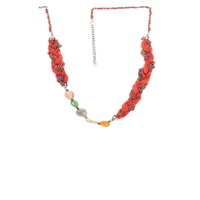

Item ID: 43949, Gender: Women, Price: 53, Category: Footwear, Subcategory: Shoes


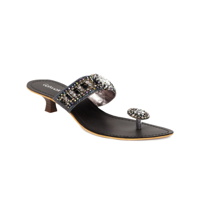

In [ ]:
# Example usage
user_id = 28301  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

Recommendations for User ID 51347 based on input articleType: Track Pants (Gender: Men)
Input Item:


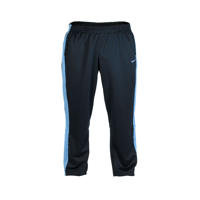

Item ID: 29262, Gender: Men, Price: 48, Category: Footwear, Subcategory: Shoes


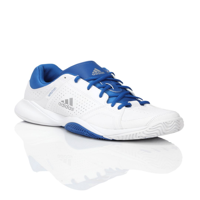

Item ID: 11391, Gender: Men, Price: 60, Category: Apparel, Subcategory: Topwear


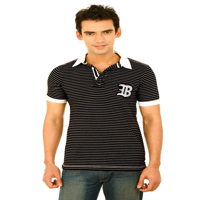

Item ID: 30025, Gender: Men, Price: 48, Category: Accessories, Subcategory: Watches


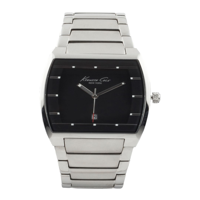

Item ID: 29004, Gender: Men, Price: 41, Category: Accessories, Subcategory: Bags


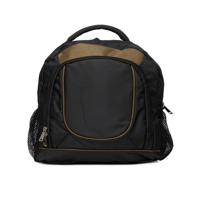

In [ ]:
# Example usage
user_id = 51347  # Example user ID
display_complete_wear_recommendations(user_id, best_svd, fashion_data, complementary_mapping, top_n=5, img_size=(200, 200))

In [ ]:
# Define complementary items with diverse categories
complementary_mapping = {
    'Skirts': ['Tshirts', 'Watches', 'Handbags', 'Heels','Necklace and Chains'],
    'Tshirts': ['Jeans', 'Belts', 'Casual Shoes', 'Backpacks'],
    'Jeans': ['Shirts', 'Belts', 'Watches', 'Casual Shoes'],
    'Dresses': ['Heels', 'Clutches', 'Earrings', 'Watches'],
    'Shirts': ['Trousers', 'Formal Shoes', 'Belts', 'Watches'],
    'Kurtas': ['Leggings', 'Dupatta', 'Earrings', 'Sandals','Watches','Formal Shoes'],
    'Handbags': ['Tshirts', 'Jeans', 'Watches', 'Heels'],
    'Formal Shoes': ['Shirts', 'Trousers', 'Belts', 'Watches'],
    'Flip Flops': ['Shorts', 'Tshirts', 'Sunglasses'],
    'Heels': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Leggings': ['Tops', 'Kurtas', 'Dupatta', 'Sandals'],
    'Backpacks': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Earrings': ['Dresses', 'Clutches', 'Heels', 'Watches'],
    'Clutches': ['Heels', 'Dresses', 'Earrings', 'Necklace and Chains'],
    'Casual Shoes': ['Jeans', 'Tshirts', 'Belts', 'Backpacks'],
    'Dupatta': ['Kurtas', 'Leggings', 'Sandals', 'Earrings'],
    'Tops': ['Skirts', 'Watches', 'Handbags', 'Heels'],
    'Ring': ['Dresses', 'Clutches', 'Necklace and Chains', 'Earrings'],
    'Flats': ['Shorts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suspenders': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Sports Shoes': ['Track Pants', 'Tshirts', 'Watches', 'Backpacks'],
    'Sunglasses': ['Tshirts', 'Jeans', 'Casual Shoes', 'Backpacks'],
    'Shorts': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Belts': ['Jeans', 'Tshirts', 'Casual Shoes', 'Watches'],
    'Sarees': ['Handbags','Earrings', 'Necklace and Chains', 'Heels','Watches'],
    'Nightdress': ['Lounge Pants', 'Robe', 'Socks', 'Slippers'],
    'Jackets': ['Jeans', 'Tshirts', 'Sneakers', 'Backpacks'],
    'Trousers': ['Shirts', 'Formal Shoes', 'Belts', 'Watches'],
    'Messenger Bag': ['Tshirts', 'Jeans', 'Casual Shoes', 'Sunglasses'],
    'Track Pants': ['Sports Shoes', 'Tshirts', 'Watches', 'Backpacks'],
    'Kurtis': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Capris': ['Tshirts', 'Flip Flops', 'Sunglasses', 'Backpacks'],
    'Sweatshirts': ['Jeans', 'Sneakers', 'Backpacks', 'Watches'],
    'Wallets': ['Jeans', 'Shirts', 'Belts', 'Watches','Trousers'],
    'Socks': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Backpacks'],
    'Necklace and Chains': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Stockings': ['Skirts', 'Heels', 'Handbags', 'Tops'],
    'Waist Pouch': ['Tshirts', 'Shorts', 'Sunglasses', 'Sneakers'],
    'Tunics': ['Leggings', 'Dupatta', 'Sandals', 'Earrings'],
    'Booties': ['Dresses', 'Leggings', 'Clutches', 'Necklace and Chains'],
    'Lounge Pants': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    'Sweaters': ['Jeans', 'Boots', 'Backpacks', 'Watches'],
    'Pendant': ['Tshirts', 'Jeans', 'Watches', 'Dresses','Necklace and Chains', 'Clutches'],
    'Duffel Bag': ['Sports Shoes', 'Track Pants', 'Tshirts', 'Watches'],
    'Tracksuits': ['Sports Shoes', 'Duffel Bag', 'Watches', 'Socks'],
    'Baby Dolls': ['Robes', 'Slippers', 'Socks', 'Nightgowns'],
    'Laptop Bag': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Night suits': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Tights': ['Tunics', 'Sweatshirts', 'Sneakers', 'Backpacks'],
    'Jeggings': ['Tops', 'Heels', 'Handbags', 'Sunglasses'],
    'Mobile Pouch': ['Jeans', 'Tshirts', 'Casual Shoes', 'Belts'],
    'Jewellery Set': ['Dresses', 'Earrings', 'Clutches', 'Heels'],
    'Lounge Shorts': ['Night Tshirts', 'Slippers', 'Robe', 'Socks'],
    #'Swimwear': ['Sunglasses', 'Flip Flops', 'Beach Bags'],
    'Swimwear': ['Sunglasses', 'Swimwear', 'Beach Bags'],
    'Bangle': ['Sarees', 'Necklace and Chains', 'Earrings', 'Sandals'],
    'Churidar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Salwar': ['Kurtas', 'Dupatta', 'Sandals', 'Earrings'],
    'Shrug': ['Tops', 'Jeans', 'Sneakers', 'Backpacks'],
    'Bracelet': ['Shirts','Jeans','Casual Shoes','Belts','Dresses', 'Necklace and Chains', 'Earrings', 'Watches'],
    'Waistcoat': ['Shirts', 'Trousers', 'Formal Shoes', 'Belts'],
    'Rucksacks': ['Tshirts', 'Jeans', 'Sneakers', 'Sunglasses'],
    'Blazers': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Rompers': ['Sandals', 'Clutches', 'Earrings', 'Watches'],
    'Robe': ['Nightdress', 'Slippers', 'Socks', 'Night Tshirts'],
    'Salwar and Dupatta': ['Kurtas', 'Sandals', 'Earrings', 'Bangles'],
    'Tablet Sleeve': ['Tshirts', 'Jeans', 'Sneakers', 'Watches'],
    'Rain Jacket': ['Track Pants', 'Sports Shoes', 'Backpacks'],
    'Lounge Tshirts': ['Lounge Pants', 'Slippers', 'Robe', 'Socks'],
    'Lehenga Choli': ['Earrings', 'Necklace and Chains', 'Bangles', 'Sandals'],
    'Sandals': ['Skirts', 'Tops', 'Handbags', 'Sunglasses'],
    'Suits': ['Shirts', 'Trousers', 'Formal Shoes', 'Watches'],
    'Travel Accessory': ['Backpacks', 'Sneakers', 'Sunglasses'],
    'Trolley Bag': ['Casual Shoes', 'Jeans', 'Tshirts', 'Watches'],
    'Watches' : ['Shirts', 'Jeans', 'Tshirts', 'Shoes'],
    'Bangle' : ['Saree', 'Dresses', 'Necklace and Chains', 'Earrings']
}



In [ ]:
import pandas as pd

# Load your dataset
file_path = 'fashion_dataset.csv' # Replace with your dataset's path
fashion_data = pd.read_csv(file_path)

# Reshape data for user-item interaction matrix creation
interaction_columns = ['user_id1', 'user_id2', 'user_id3', 'user_id4', 'user_id5']
interaction_data = fashion_data.melt(id_vars=['id'],
                                     value_vars=interaction_columns,
                                     var_name='interaction_type',
                                     value_name='user_id').dropna()
print(interaction_data)
# Aggregate interactions by user_id and item_id
interaction_data = interaction_data[['user_id', 'id']].drop_duplicates()
interaction_data['interaction'] = 1  # Assign a default interaction weight

# Create a user-item interaction matrix
interaction_matrix = interaction_data.pivot(index='user_id', columns='id', values='interaction').fillna(0)

print("Interaction Matrix Shape:", interaction_matrix.shape)


           id interaction_type  user_id
0        8493         user_id1    93810
1       30757         user_id1    24592
2       14881         user_id1    13278
3       48449         user_id1    46048
4        4697         user_id1    42098
...       ...              ...      ...
182415  45378         user_id5    40828
182416   8219         user_id5    65026
182417  35177         user_id5    67438
182418   8673         user_id5    31566
182419   5864         user_id5    45003

[182420 rows x 3 columns]
Interaction Matrix Shape: (4891, 36484)


In [ ]:
interaction_data

,user_id,id,interaction
0,93810,8493,1
1,24592,30757,1
2,13278,14881,1
3,46048,48449,1
4,42098,4697,1
...,...,...,...
182415,40828,45378,1
182416,65026,8219,1
182417,67438,35177,1
182418,31566,8673,1


In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

# Convert interaction matrix to a numpy array
interaction_matrix_array = interaction_matrix.values

# Perform SVD
U, sigma, Vt = svds(interaction_matrix_array, k=50)  # k = number of latent factors
sigma = np.diag(sigma)  # Convert sigma into a diagonal matrix

# Reconstruct the interaction matrix
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

# Convert predictions back to a DataFrame
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=interaction_matrix.index, columns=interaction_matrix.columns)
'''
# Function to recommend items for a given user
def recommend_items_svd(user_id, num_recommendations=5):
    user_row = predicted_ratings_df.loc[user_id]
    # Filter out already interacted items
    interacted_items = interaction_matrix.loc[user_id]
    recommendations = user_row[interacted_items == 0].nlargest(num_recommendations)
    return recommendations
'''

'\n# Function to recommend items for a given user\ndef recommend_items_svd(user_id, num_recommendations=5):\n    user_row = predicted_ratings_df.loc[user_id]\n    # Filter out already interacted items\n    interacted_items = interaction_matrix.loc[user_id]\n    recommendations = user_row[interacted_items == 0].nlargest(num_recommendations)\n    return recommendations\n'

In [ ]:
predicted_ratings_df

id,1163,1164,1165,1525,1526,1528,1529,1530,1531,1532,...,59939,59940,59941,59942,59943,59944,59945,59998,59999,60000
user_id,,,,,,,,,,,,,,,,,,,,,
10022,-1.375770e-16,-1.715286e-16,2.728171e-16,4.071378e-18,1.146069e-17,-1.642296e-16,4.524271e-16,8.328291e-17,5.284981e-17,-9.977734e-16,...,-3.074438e-16,-1.705878e-16,-5.427809e-17,-2.741743e-16,-4.079828e-16,-3.901298e-16,2.080258e-16,2.059866e-03,1.055055e-03,-5.824293e-03
10053,7.619155e-16,-2.290979e-16,5.732065e-16,6.231877e-17,-9.433723e-17,-8.963993e-17,-2.169171e-16,4.099156e-17,1.157060e-16,-4.863787e-16,...,-3.564827e-16,1.139551e-15,1.853751e-16,-5.576434e-16,-9.061695e-16,-1.790063e-16,-1.964552e-16,1.847853e-03,-7.171254e-04,1.291947e-02
10074,-3.046717e-16,-5.111324e-16,-2.329426e-16,7.820034e-17,-1.336337e-16,-2.564411e-16,1.498856e-16,6.909942e-17,-1.996480e-16,2.718165e-17,...,2.799192e-16,-3.300247e-16,9.332167e-17,5.539425e-16,3.500250e-16,-5.442168e-16,6.806960e-17,9.224784e-05,5.576784e-04,1.072967e-02
10088,5.746048e-02,2.471469e-02,6.424151e-03,1.457994e-15,-1.796986e-15,-1.500378e-02,-4.101602e-02,-4.660424e-03,-9.924086e-03,-1.438617e-02,...,1.624220e-02,-1.257628e-02,-9.734266e-03,-1.646294e-02,1.555527e-02,2.639179e-02,-8.698653e-03,2.222427e-15,1.758430e-15,-1.450501e-15
10089,3.136008e-03,9.875218e-04,-7.558029e-04,-5.455072e-17,9.792947e-17,3.159811e-03,4.709754e-03,1.844971e-03,1.004015e-03,2.437942e-03,...,1.860974e-03,3.918758e-03,6.550063e-04,5.001670e-03,2.909879e-04,3.729106e-03,1.801514e-03,-1.335772e-16,1.321816e-16,6.029638e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99952,1.566565e-03,1.579278e-03,1.795437e-03,-3.730261e-17,5.498034e-17,2.667745e-03,1.525540e-03,1.178993e-03,1.514176e-03,2.401700e-03,...,-5.391169e-04,4.102201e-03,1.328225e-03,3.605319e-03,4.457366e-04,1.507697e-03,8.784441e-04,4.019092e-17,-5.188373e-17,-4.187235e-16
99957,7.416384e-04,3.326364e-03,-7.411228e-05,1.474019e-17,-3.750499e-17,1.753578e-03,-7.196895e-04,1.223402e-03,1.477501e-03,2.421656e-03,...,-2.123389e-04,-5.874349e-05,1.914395e-03,5.379627e-03,3.302301e-03,2.952147e-03,1.512496e-03,-1.134107e-17,1.176163e-16,4.947688e-16
99974,-7.672077e-17,-6.588936e-16,-1.482750e-16,-3.468160e-17,3.414843e-17,-1.049413e-16,-7.592847e-16,6.848595e-17,1.473097e-16,-7.458225e-16,...,7.673153e-18,6.840951e-17,-2.756080e-17,1.135901e-16,-1.974283e-16,7.057392e-17,2.769281e-16,6.276275e-04,3.544767e-03,4.253358e-03


In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808327 sha256=11f758dd53c2c4e0c9066db30e8372ffb40b0566b354618da2e6f1f6bcce2987
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [ ]:
from lightfm import LightFM
from scipy.sparse import csr_matrix

# Prepare the sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix.values)

# Define the PMF model
pmf_model = LightFM(loss='warp', no_components=50)  # 50 latent dimensions (tunable)

# Train the PMF model
pmf_model.fit(interaction_matrix_sparse, epochs=10, num_threads=4)

# Save the trained model
print("PMF model trained successfully!")


PMF model trained successfully!


In [ ]:
interaction_matrix_sparse

<4891x36484 sparse matrix of type '<class 'numpy.float64'>'
	with 182100 stored elements in Compressed Sparse Row format>

In [ ]:
def recommend_items_with_complementary_mapping(
    model, user_id, item_id, num_recommendations=5
):
    # Ensure user and item exist
    if user_id not in interaction_matrix.index:
        return f"User {user_id} not found in the interaction matrix."
    if item_id not in fashion_data['id'].values:
        return f"Item {item_id} not found in the dataset."

    # Get user embedding
    user_idx = interaction_matrix.index.get_loc(user_id)
    user_embedding = model.user_embeddings[user_idx]

    # Input item details
    input_item = fashion_data[fashion_data['id'] == item_id].iloc[0]
    input_gender = input_item['gender']
    input_article_type = input_item['articleType']

    # Get complementary item types from the mapping
    complementary_items = complementary_mapping.get(input_article_type, [])
    if not complementary_items:
        return f"No complementary items defined for articleType: {input_article_type}"

    # Filter dataset for complementary items
    filtered_items = fashion_data[
        (fashion_data['articleType'].isin(complementary_items)) &
        (fashion_data['gender'] == input_gender)  # Match gender
    ]

    # Exclude the input item from recommendations
    filtered_items = filtered_items[filtered_items['id'] != item_id]

    # Calculate scores for remaining items
    item_indices = filtered_items.index
    item_embeddings = model.item_embeddings[item_indices]
    scores = user_embedding @ item_embeddings.T

    # Rank items by score
    filtered_items['score'] = scores
    ranked_items = filtered_items.sort_values(by='score', ascending=False)

    # Ensure unique articleType in recommendations
    unique_recommendations = ranked_items.drop_duplicates(subset='articleType').head(num_recommendations)

    # Return input item and final recommendations
    return input_item, unique_recommendations[['id', 'gender', 'articleType', 'subCategory']]


In [ ]:
user_id = 93810
item_id = 8493  # Input item_id

# Call the function to get recommendations
result = recommend_items_with_complementary_mapping(pmf_model, user_id, item_id, num_recommendations=5)

if isinstance(result, str):  # If an error message is returned
    print(result)
else:
    input_item_details, recommendations = result

    # Display input item details
    print(f"Input item details:\n{input_item_details[['id', 'gender', 'articleType', 'subCategory']]}")

    # Display top 5 recommendations
    print(f"\nTop recommendations for user {user_id} based on item {item_id}:")
    print(recommendations)

Input item details:
id                   8493
gender              Women
articleType        Skirts
subCategory    Bottomwear
Name: 0, dtype: object

Top recommendations for user 93810 based on item 8493:
          id gender          articleType subCategory
18214  38593  Women              Tshirts     Topwear
5113    8102  Women              Watches     Watches
29598  20385  Women             Handbags        Bags
24617  14862  Women  Necklace and Chains   Jewellery
7690   56898  Women                Heels       Shoes


In [ ]:
user_id = 31747
item_id = 59622  # Input item_id

# Call the function to get recommendations
result = recommend_items_with_complementary_mapping(pmf_model, user_id, item_id, num_recommendations=5)

if isinstance(result, str):  # If an error message is returned
    print(result)
else:
    input_item_details, recommendations = result

    # Display input item details
    print(f"Input item details:\n{input_item_details[['id', 'gender', 'articleType', 'subCategory']]}")

    # Display top 5 recommendations
    print(f"\nTop recommendations for user {user_id} based on item {item_id}:")
    print(recommendations)

Input item details:
id              59622
gender          Women
articleType    Sarees
subCategory     Saree
Name: 226, dtype: object

Top recommendations for user 31747 based on item 59622:
          id gender          articleType subCategory
34957   8100  Women              Watches     Watches
36318  14808  Women             Handbags        Bags
32034  47569  Women                Heels       Shoes
14466  43829  Women             Earrings   Jewellery
28850  46126  Women  Necklace and Chains   Jewellery
